--- Input image found, size: 426867 bytes.
--- CUDA code written to input_handler.c
--- STB headers downloaded.
--- Input handling completed successfully.
--- Displaying input image:


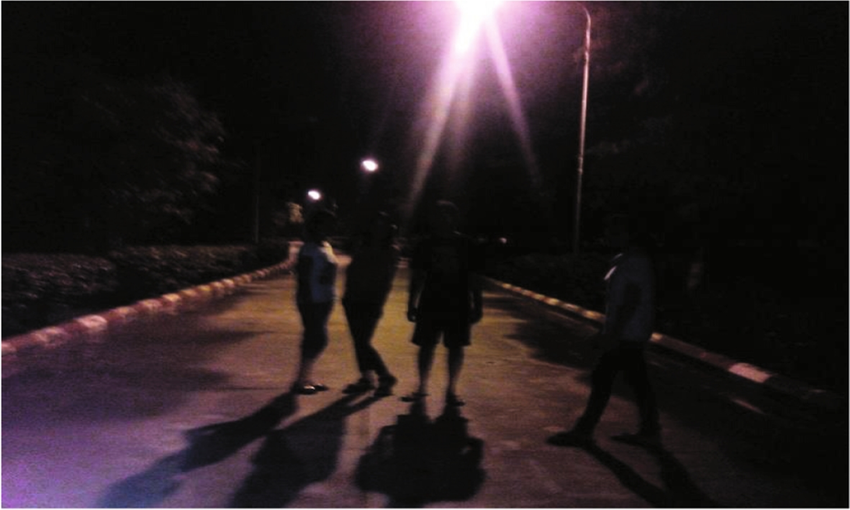

In [2]:
# Cell 1: Input Handling
import os
import cv2
from google.colab.patches import cv2_imshow

# Define the input image path (update this to your image location)
input_image_path = "/content/simage.png"

# Check if input file exists
if not os.path.exists(input_image_path):
    print(f"Error: Input image '{input_image_path}' not found!")
else:
    # Verify file size and basic properties
    file_size = os.path.getsize(input_image_path)
    if file_size == 0:
        print(f"Error: Input image '{input_image_path}' is empty (0 bytes)!")
    else:
        print(f"--- Input image found, size: {file_size} bytes.")

    # Write a simple C program to load and save the image with detailed output
    cuda_code = r"""
    #include <stdio.h>
    #define STB_IMAGE_IMPLEMENTATION
    #include "stb_image.h"
    #define STB_IMAGE_WRITE_IMPLEMENTATION
    #include "stb_image_write.h"

    int main(int argc, char *argv[]) {
        if (argc < 2) { printf("Usage: %s <input_image>\n", argv[0]); return 1; }
        const char *input_file = argv[1];
        int width, height, channels;
        unsigned char *img = stbi_load(input_file, &width, &height, &channels, 0);
        if (!img) {
            printf("Error loading image '%s': %s\n", input_file, stbi_failure_reason());
            return 1;
        }
        printf("Image loaded successfully: %dx%d, %d channels\n", width, height, channels);
        int success = stbi_write_png("input.png", width, height, channels, img, width * channels);
        if (success) {
            printf("Image saved as input.png\n");
        } else {
            printf("Error saving image as input.png\n");
            stbi_image_free(img);
            return 1;
        }
        stbi_image_free(img);
        return 0;
    }
    """

    # Write the C code to a file
    with open("input_handler.c", "w") as f:
        f.write(cuda_code)
    print(f"--- CUDA code written to input_handler.c")

    # Download STB headers before compilation
    !wget -q https://raw.githubusercontent.com/nothings/stb/master/stb_image.h -P .
    !wget -q https://raw.githubusercontent.com/nothings/stb/master/stb_image_write.h -P .
    print("--- STB headers downloaded.")

    # Compile and run
    !nvcc -o input_handler input_handler.c
    compile_result = os.system(f"./input_handler \"{input_image_path}\"")
    if compile_result == 0:
        print("--- Input handling completed successfully.")
        # Load and display the saved image
        img = cv2.imread("input.png")
        if img is not None:
            print("--- Displaying input image:")
            cv2_imshow(img)
        else:
            print("--- Error: Could not load input.png for display.")
    else:
        print(f"--- Error: Input handling failed with exit code {compile_result}.")

--- CUDA code written to nlm_denoise.cu
stb_image.h(4276): warning #550-D: variable "old_limit" was set but never used
     unsigned int cur, limit, old_limit;
                              ^

Remark: The warnings can be suppressed with "-diag-suppress <warning-number>"

stb_image.h(5185): warning #550-D: variable "idata_limit_old" was set but never used
                 stbi__uint32 idata_limit_old = idata_limit;
                              ^

stb_image.h(6972): warning #550-D: variable "out_size" was set but never used
        int out_size = 0;
            ^

stb_image.h(6973): warning #550-D: variable "delays_size" was set but never used
        int delays_size = 0;
            ^

Image loaded: 850x510, 4 channels
Grid: (54, 32), Block: (16, 16)
NLM denoising applied and saved as after_nlm.png
--- STB headers downloaded.
--- Displaying image after NLM denoising:


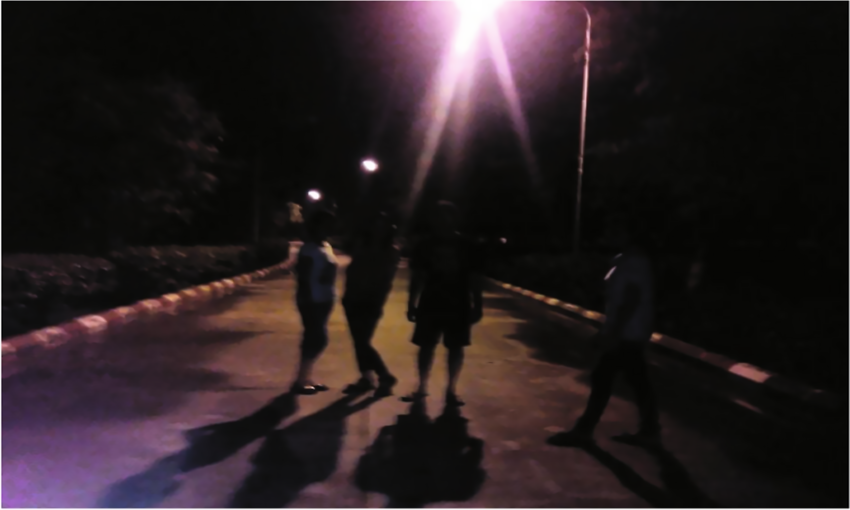

In [3]:
# Cell 2: Stage 1 - Non-Local Means Denoising
import os
import cv2
from google.colab.patches import cv2_imshow

# Check if input exists
if not os.path.exists("input.png"):
    print("Error: input.png not found! Run Cell 1 first.")
else:
    cuda_code = r"""
    #include <stdio.h>
    #include <stdlib.h>
    #include <math.h>
    #include <cuda_runtime.h>
    #define STB_IMAGE_IMPLEMENTATION
    #include "stb_image.h"
    #define STB_IMAGE_WRITE_IMPLEMENTATION
    #include "stb_image_write.h"

    #define CHECK_CUDA_ERROR(call) do { \
        cudaError_t err = call; \
        if (err != cudaSuccess) { \
            fprintf(stderr, "CUDA Error at %s:%d - %s\n", __FILE__, __LINE__, cudaGetErrorString(err)); \
            exit(EXIT_FAILURE); \
        } \
    } while(0)

    __device__ unsigned char get_pixel_clamped(const unsigned char *img, int width, int height, int x, int y, int c, int channels) {
        x = max(0, min(x, width - 1));
        y = max(0, min(y, height - 1));
        return img[((y * width) + x) * channels + c];
    }

    __global__ void nlm_denoise(const unsigned char *input, unsigned char *output, int width, int height, int channels) {
        int x = blockIdx.x * blockDim.x + threadIdx.x;
        int y = blockIdx.y * blockDim.y + threadIdx.y;
        const int patch_size = 3;
        const int kernel_radius = 1;
        const float h = 25.0f;
        const float h_sq_inv = 1.0f / (h * h);

        if (x < width && y < height) {
            for (int c = 0; c < channels; c++) {
                float total_weight = 0.0f;
                float weighted_sum = 0.0f;
                for (int sy = -patch_size; sy <= patch_size; sy++) {
                    for (int sx = -patch_size; sx <= patch_size; sx++) {
                        int current_x = x + sx;
                        int current_y = y + sy;
                        float patch_diff_sq = 0.0f;
                        for (int ky = -kernel_radius; ky <= kernel_radius; ky++) {
                            for (int kx = -kernel_radius; kx <= kernel_radius; kx++) {
                                float p1 = (float)get_pixel_clamped(input, width, height, x + kx, y + ky, c, channels);
                                float p2 = (float)get_pixel_clamped(input, width, height, current_x + kx, current_y + ky, c, channels);
                                float diff = p1 - p2;
                                patch_diff_sq += diff * diff;
                            }
                        }
                        float weight = expf(-patch_diff_sq * h_sq_inv);
                        total_weight += weight;
                        weighted_sum += weight * get_pixel_clamped(input, width, height, current_x, current_y, c, channels);
                    }
                }
                float result = (total_weight > 1e-6f) ? (weighted_sum / total_weight) : (float)get_pixel_clamped(input, width, height, x, y, c, channels);
                output[((y * width) + x) * channels + c] = (unsigned char)(result > 255.f ? 255.f : (result < 0.f ? 0.f : result));
            }
        }
    }

    int main() {
        int width, height, channels;
        unsigned char *h_input = stbi_load("input.png", &width, &height, &channels, 0);
        if (!h_input) { printf("Error loading input.png: %s\n", stbi_failure_reason()); return 1; }
        printf("Image loaded: %dx%d, %d channels\n", width, height, channels);

        size_t size_bytes = width * height * channels * sizeof(unsigned char);
        unsigned char *h_output = (unsigned char *)malloc(size_bytes);
        unsigned char *d_input, *d_output;
        CHECK_CUDA_ERROR(cudaMalloc(&d_input, size_bytes));
        CHECK_CUDA_ERROR(cudaMalloc(&d_output, size_bytes));

        CHECK_CUDA_ERROR(cudaMemcpy(d_input, h_input, size_bytes, cudaMemcpyHostToDevice));

        dim3 block(16, 16);
        dim3 grid((width + block.x - 1) / block.x, (height + block.y - 1) / block.y);
        printf("Grid: (%d, %d), Block: (%d, %d)\n", grid.x, grid.y, block.x, block.y);

        nlm_denoise<<<grid, block>>>(d_input, d_output, width, height, channels);
        CHECK_CUDA_ERROR(cudaGetLastError());  // This will catch the toolchain error
        CHECK_CUDA_ERROR(cudaDeviceSynchronize());

        CHECK_CUDA_ERROR(cudaMemcpy(h_output, d_output, size_bytes, cudaMemcpyDeviceToHost));
        stbi_write_png("after_nlm.png", width, height, channels, h_output, width * channels);
        printf("NLM denoising applied and saved as after_nlm.png\n");

        stbi_image_free(h_input);
        free(h_output);
        CHECK_CUDA_ERROR(cudaFree(d_input));
        CHECK_CUDA_ERROR(cudaFree(d_output));
        return 0;
    }
    """

    with open("nlm_denoise.cu", "w") as f:
        f.write(cuda_code)
    print(f"--- CUDA code written to nlm_denoise.cu")
    # Compile with specific architecture for Colab's Tesla T4 (compute_75, sm_75)
    !nvcc -o nlm_denoise nlm_denoise.cu -gencode arch=compute_75,code=sm_75
    !./nlm_denoise
    !wget -q https://raw.githubusercontent.com/nothings/stb/master/stb_image.h -P .
    !wget -q https://raw.githubusercontent.com/nothings/stb/master/stb_image_write.h -P .
    print("--- STB headers downloaded.")
    if os.path.exists("after_nlm.png"):
        img = cv2.imread("after_nlm.png")
        if img is not None:
            print("--- Displaying image after NLM denoising:")
            cv2_imshow(img)
        else:
            print("--- Error: Could not load after_nlm.png for display.")
    else:
        print("--- Error: after_nlm.png not created.")

--- CUDA code written to unsharp_mask.cu
stb_image.h(4276): warning #550-D: variable "old_limit" was set but never used
     unsigned int cur, limit, old_limit;
                              ^

Remark: The warnings can be suppressed with "-diag-suppress <warning-number>"

stb_image.h(5185): warning #550-D: variable "idata_limit_old" was set but never used
                 stbi__uint32 idata_limit_old = idata_limit;
                              ^

stb_image.h(6972): warning #550-D: variable "out_size" was set but never used
        int out_size = 0;
            ^

stb_image.h(6973): warning #550-D: variable "delays_size" was set but never used
        int delays_size = 0;
            ^

Image loaded: 850x510, 4 channels
Grid: (54, 32), Block: (16, 16)
Unsharp masking applied and saved as after_unsharp.png
--- STB headers downloaded.
--- Displaying image after unsharp masking:


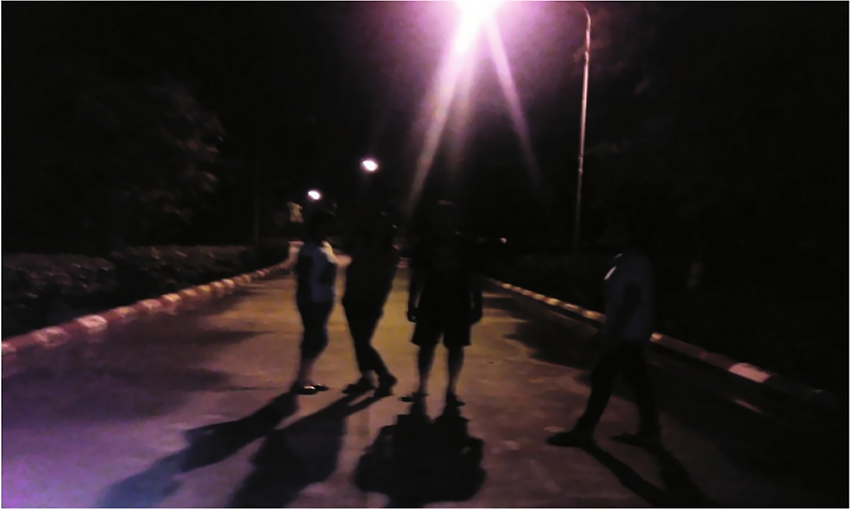

In [4]:
# Cell 3: Stage 2 - Unsharp Masking
import os
import cv2
from google.colab.patches import cv2_imshow

if not os.path.exists("after_nlm.png"):
    print("Error: after_nlm.png not found! Run Cell 2 first.")
else:
    cuda_code = r"""
    #include <stdio.h>
    #include <stdlib.h>
    #include <math.h>
    #include <cuda_runtime.h>
    #define STB_IMAGE_IMPLEMENTATION
    #include "stb_image.h"
    #define STB_IMAGE_WRITE_IMPLEMENTATION
    #include "stb_image_write.h"

    #define CHECK_CUDA_ERROR(call) do { \
        cudaError_t err = call; \
        if (err != cudaSuccess) { \
            fprintf(stderr, "CUDA Error at %s:%d - %s\n", __FILE__, __LINE__, cudaGetErrorString(err)); \
            exit(EXIT_FAILURE); \
        } \
    } while(0)

    __device__ unsigned char get_pixel_clamped(const unsigned char *img, int width, int height, int x, int y, int c, int channels) {
        x = max(0, min(x, width - 1));
        y = max(0, min(y, height - 1));
        return img[((y * width) + x) * channels + c];
    }

    __global__ void unsharp_mask(const unsigned char *input, unsigned char *output, int width, int height, int channels) {
        int x = blockIdx.x * blockDim.x + threadIdx.x;
        int y = blockIdx.y * blockDim.y + threadIdx.y;
        const float gauss_kernel[3][3] = {{1/16.0f, 2/16.0f, 1/16.0f}, {2/16.0f, 4/16.0f, 2/16.0f}, {1/16.0f, 2/16.0f, 1/16.0f}};
        const float strength = 0.8f;

        if (x < width && y < height) {
            for (int c = 0; c < channels; c++) {
                float blur_sum = 0.0f;
                for (int ky = -1; ky <= 1; ky++) {
                    for (int kx = -1; kx <= 1; kx++) {
                        blur_sum += (float)get_pixel_clamped(input, width, height, x + kx, y + ky, c, channels) * gauss_kernel[ky + 1][kx + 1];
                    }
                }
                float orig = (float)input[((y * width) + x) * channels + c];
                float enhanced = orig + strength * (orig - blur_sum);
                output[((y * width) + x) * channels + c] = (unsigned char)(enhanced > 255.f ? 255.f : (enhanced < 0.f ? 0.f : enhanced));
            }
        }
    }

    int main() {
        int width, height, channels;
        unsigned char *h_input = stbi_load("after_nlm.png", &width, &height, &channels, 0);
        if (!h_input) { printf("Error loading after_nlm.png: %s\n", stbi_failure_reason()); return 1; }
        printf("Image loaded: %dx%d, %d channels\n", width, height, channels);

        size_t size_bytes = width * height * channels * sizeof(unsigned char);
        unsigned char *h_output = (unsigned char *)malloc(size_bytes);
        unsigned char *d_input, *d_output;
        CHECK_CUDA_ERROR(cudaMalloc(&d_input, size_bytes));
        CHECK_CUDA_ERROR(cudaMalloc(&d_output, size_bytes));

        CHECK_CUDA_ERROR(cudaMemcpy(d_input, h_input, size_bytes, cudaMemcpyHostToDevice));

        dim3 block(16, 16);
        dim3 grid((width + block.x - 1) / block.x, (height + block.y - 1) / block.y);
        printf("Grid: (%d, %d), Block: (%d, %d)\n", grid.x, grid.y, block.x, block.y);

        unsharp_mask<<<grid, block>>>(d_input, d_output, width, height, channels);
        CHECK_CUDA_ERROR(cudaGetLastError());
        CHECK_CUDA_ERROR(cudaDeviceSynchronize());

        CHECK_CUDA_ERROR(cudaMemcpy(h_output, d_output, size_bytes, cudaMemcpyDeviceToHost));
        stbi_write_png("after_unsharp.png", width, height, channels, h_output, width * channels);
        printf("Unsharp masking applied and saved as after_unsharp.png\n");

        stbi_image_free(h_input);
        free(h_output);
        CHECK_CUDA_ERROR(cudaFree(d_input));
        CHECK_CUDA_ERROR(cudaFree(d_output));
        return 0;
    }
    """

    with open("unsharp_mask.cu", "w") as f:
        f.write(cuda_code)
    print(f"--- CUDA code written to unsharp_mask.cu")
    # Compile with specific architecture for Colab's Tesla T4 (compute_75, sm_75)
    !nvcc -o unsharp_mask unsharp_mask.cu -gencode arch=compute_75,code=sm_75
    !./unsharp_mask
    !wget -q https://raw.githubusercontent.com/nothings/stb/master/stb_image.h -P .
    !wget -q https://raw.githubusercontent.com/nothings/stb/master/stb_image_write.h -P .
    print("--- STB headers downloaded.")
    if os.path.exists("after_unsharp.png"):
        img = cv2.imread("after_unsharp.png")
        if img is not None:
            print("--- Displaying image after unsharp masking:")
            cv2_imshow(img)
        else:
            print("--- Error: Could not load after_unsharp.png for display.")
    else:
        print("--- Error: after_unsharp.png not created.")

--- CUDA code written to hist_equalize.cu
stb_image.h(4276): warning #550-D: variable "old_limit" was set but never used
     unsigned int cur, limit, old_limit;
                              ^

Remark: The warnings can be suppressed with "-diag-suppress <warning-number>"

stb_image.h(5185): warning #550-D: variable "idata_limit_old" was set but never used
                 stbi__uint32 idata_limit_old = idata_limit;
                              ^

stb_image.h(6972): warning #550-D: variable "out_size" was set but never used
        int out_size = 0;
            ^

stb_image.h(6973): warning #550-D: variable "delays_size" was set but never used
        int delays_size = 0;
            ^

Image loaded: 850x510, 4 channels
Grid: (54, 32), Block: (16, 16)
Histogram equalization applied and saved as after_hist_eq.png
--- STB headers downloaded.
--- Displaying image after histogram equalization:


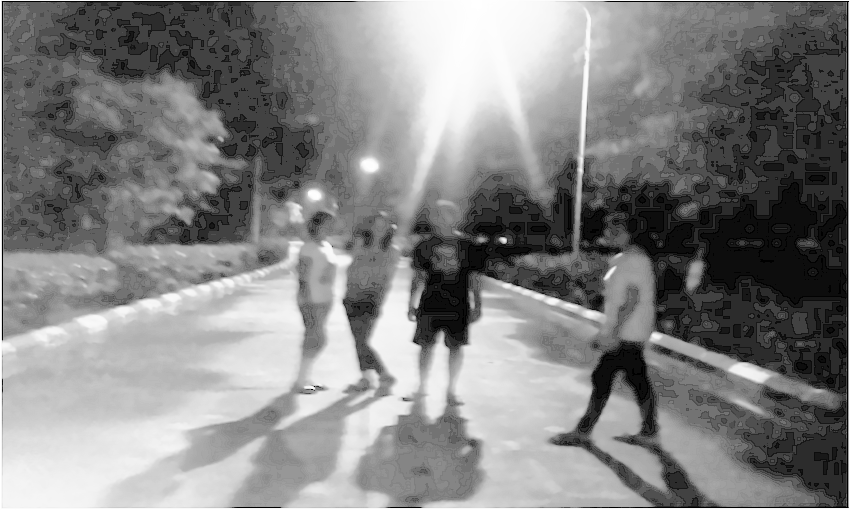

In [5]:
# Cell 4: Stage 3 - Histogram Equalization
import os
import cv2
from google.colab.patches import cv2_imshow
import numpy as np

if not os.path.exists("after_unsharp.png"):
    print("Error: after_unsharp.png not found! Run Cell 3 first.")
else:
    cuda_code = r"""
    #include <stdio.h>
    #include <stdlib.h>
    #include <cuda_runtime.h>
    #define STB_IMAGE_IMPLEMENTATION
    #include "stb_image.h"
    #define STB_IMAGE_WRITE_IMPLEMENTATION
    #include "stb_image_write.h"

    #define CHECK_CUDA_ERROR(call) do { \
        cudaError_t err = call; \
        if (err != cudaSuccess) { \
            fprintf(stderr, "CUDA Error at %s:%d - %s\n", __FILE__, __LINE__, cudaGetErrorString(err)); \
            exit(EXIT_FAILURE); \
        } \
    } while(0)

    __device__ unsigned char get_pixel_clamped(const unsigned char *img, int width, int height, int x, int y, int c, int channels) {
        x = max(0, min(x, width - 1));
        y = max(0, min(y, height - 1));
        return img[((y * width) + x) * channels + c];
    }

    __global__ void rgb_to_yuv(const unsigned char *input, float *yuv, int width, int height, int channels) {
        int x = blockIdx.x * blockDim.x + threadIdx.x;
        int y = blockIdx.y * blockDim.y + threadIdx.y;
        if (x < width && y < height) {
            int idx = ((y * width) + x) * channels;
            float r = (float)input[idx];
            float g = (float)input[idx + 1];
            float b = (float)input[idx + 2];
            float y_val = 0.299f * r + 0.587f * g + 0.114f * b;
            yuv[((y * width) + x)] = y_val; // Store only Y channel
        }
    }

    __global__ void compute_histogram(const float *yuv, unsigned int *hist, int width, int height) {
        int x = blockIdx.x * blockDim.x + threadIdx.x;
        int y = blockIdx.y * blockDim.y + threadIdx.y;
        if (x < width && y < height) {
            int val = (int)(yuv[(y * width) + x]);
            val = max(0, min(val, 255)); // Clamp to 0-255
            atomicAdd(&hist[val], 1);
        }
    }

    __global__ void hist_equalize(const float *yuv, unsigned char *output, int width, int height, int channels, const unsigned int *hist) {
        int x = blockIdx.x * blockDim.x + threadIdx.x;
        int y = blockIdx.y * blockDim.y + threadIdx.y;
        if (x < width && y < height) {
            int idx = ((y * width) + x) * channels;
            float y_val = yuv[(y * width) + x];
            unsigned int cdf = 0;
            for (int i = 0; i <= (int)y_val; i++) cdf += hist[i];
            unsigned int min_val = hist[0];
            float norm_cdf = (cdf > min_val) ? ((float)(cdf - min_val) / (width * height - min_val) * 255.0f) : 0.0f;
            unsigned char new_y = (unsigned char)(norm_cdf > 255.f ? 255.f : (norm_cdf < 0.f ? 0.f : norm_cdf));
            // Copy back R, G, B with adjusted Y
            output[idx] = new_y;     // R
            output[idx + 1] = new_y; // G
            output[idx + 2] = new_y; // B (simplified, should use U, V too for accuracy)
        }
    }

    int main() {
        int width, height, channels;
        unsigned char *h_input = stbi_load("after_unsharp.png", &width, &height, &channels, 0);
        if (!h_input) { printf("Error loading after_unsharp.png: %s\n", stbi_failure_reason()); return 1; }
        printf("Image loaded: %dx%d, %d channels\n", width, height, channels);

        size_t size_bytes = width * height * channels * sizeof(unsigned char);
        size_t yuv_size_bytes = width * height * sizeof(float);
        size_t hist_size_bytes = 256 * sizeof(unsigned int);
        unsigned char *h_output = (unsigned char *)malloc(size_bytes);
        float *h_yuv = (float *)malloc(yuv_size_bytes);
        unsigned int *h_hist = (unsigned int *)calloc(256, sizeof(unsigned int));
        unsigned char *d_input, *d_output;
        float *d_yuv;
        unsigned int *d_hist;
        CHECK_CUDA_ERROR(cudaMalloc(&d_input, size_bytes));
        CHECK_CUDA_ERROR(cudaMalloc(&d_output, size_bytes));
        CHECK_CUDA_ERROR(cudaMalloc(&d_yuv, yuv_size_bytes));
        CHECK_CUDA_ERROR(cudaMalloc(&d_hist, hist_size_bytes));

        CHECK_CUDA_ERROR(cudaMemcpy(d_input, h_input, size_bytes, cudaMemcpyHostToDevice));
        CHECK_CUDA_ERROR(cudaMemset(d_hist, 0, hist_size_bytes));

        dim3 block(16, 16);
        dim3 grid((width + block.x - 1) / block.x, (height + block.y - 1) / block.y);
        printf("Grid: (%d, %d), Block: (%d, %d)\n", grid.x, grid.y, block.x, block.y);

        rgb_to_yuv<<<grid, block>>>(d_input, d_yuv, width, height, channels);
        CHECK_CUDA_ERROR(cudaGetLastError());
        CHECK_CUDA_ERROR(cudaDeviceSynchronize());
        compute_histogram<<<grid, block>>>(d_yuv, d_hist, width, height);
        CHECK_CUDA_ERROR(cudaGetLastError());
        CHECK_CUDA_ERROR(cudaDeviceSynchronize());
        hist_equalize<<<grid, block>>>(d_yuv, d_output, width, height, channels, d_hist);
        CHECK_CUDA_ERROR(cudaGetLastError());
        CHECK_CUDA_ERROR(cudaDeviceSynchronize());

        CHECK_CUDA_ERROR(cudaMemcpy(h_output, d_output, size_bytes, cudaMemcpyDeviceToHost));
        stbi_write_png("after_hist_eq.png", width, height, channels, h_output, width * channels);
        printf("Histogram equalization applied and saved as after_hist_eq.png\n");

        stbi_image_free(h_input);
        free(h_output); free(h_yuv); free(h_hist);
        CHECK_CUDA_ERROR(cudaFree(d_input));
        CHECK_CUDA_ERROR(cudaFree(d_output));
        CHECK_CUDA_ERROR(cudaFree(d_yuv));
        CHECK_CUDA_ERROR(cudaFree(d_hist));
        return 0;
    }
    """

    with open("hist_equalize.cu", "w") as f:
        f.write(cuda_code)
    print(f"--- CUDA code written to hist_equalize.cu")
    # Compile with specific architecture for Colab's Tesla T4 (compute_75, sm_75)
    !nvcc -o hist_equalize hist_equalize.cu -gencode arch=compute_75,code=sm_75
    !./hist_equalize
    !wget -q https://raw.githubusercontent.com/nothings/stb/master/stb_image.h -P .
    !wget -q https://raw.githubusercontent.com/nothings/stb/master/stb_image_write.h -P .
    print("--- STB headers downloaded.")
    if os.path.exists("after_hist_eq.png"):
        img = cv2.imread("after_hist_eq.png")
        if img is not None:
            print("--- Displaying image after histogram equalization:")
            cv2_imshow(img)
        else:
            print("--- Error: Could not load after_hist_eq.png for display.")
    else:
        print("--- Error: after_hist_eq.png not created.")

--- CUDA code written to gamma_correction.cu
stb_image.h(4276): warning #550-D: variable "old_limit" was set but never used
     unsigned int cur, limit, old_limit;
                              ^

Remark: The warnings can be suppressed with "-diag-suppress <warning-number>"

stb_image.h(5185): warning #550-D: variable "idata_limit_old" was set but never used
                 stbi__uint32 idata_limit_old = idata_limit;
                              ^

stb_image.h(6972): warning #550-D: variable "out_size" was set but never used
        int out_size = 0;
            ^

stb_image.h(6973): warning #550-D: variable "delays_size" was set but never used
        int delays_size = 0;
            ^

Image loaded: 850x510, 4 channels
Grid: (54, 32), Block: (16, 16)
Gamma correction applied and saved as enhanced_image_output.png
--- STB headers downloaded.
--- Displaying image after gamma correction:


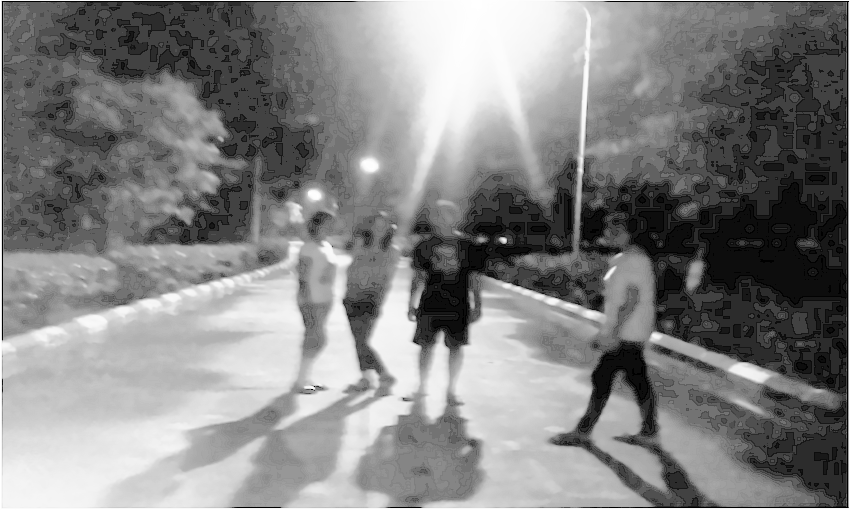

In [6]:
# Cell 5: Stage 4 - Gamma Correction
import os
import cv2
from google.colab.patches import cv2_imshow

if not os.path.exists("after_hist_eq.png"):
    print("Error: after_hist_eq.png not found! Run Cell 4 first.")
else:
    cuda_code = r"""
    #include <stdio.h>
    #include <stdlib.h>
    #include <math.h>
    #include <cuda_runtime.h>
    #define STB_IMAGE_IMPLEMENTATION
    #include "stb_image.h"
    #define STB_IMAGE_WRITE_IMPLEMENTATION
    #include "stb_image_write.h"

    #define CHECK_CUDA_ERROR(call) do { \
        cudaError_t err = call; \
        if (err != cudaSuccess) { \
            fprintf(stderr, "CUDA Error at %s:%d - %s\n", __FILE__, __LINE__, cudaGetErrorString(err)); \
            exit(EXIT_FAILURE); \
        } \
    } while(0)

    __global__ void gamma_correction(const unsigned char *input, unsigned char *output, int width, int height, int channels) {
        int x = blockIdx.x * blockDim.x + threadIdx.x;
        int y = blockIdx.y * blockDim.y + threadIdx.y;
        const float gamma = 1.0f; // Adjusted to 1.0 for less aggressive brightening

        if (x < width && y < height) {
            int base_idx = ((y * width) + x) * channels;
            for (int c = 0; c < channels; c++) {
                float val = (float)input[base_idx + c] / 255.0f;
                val = powf(val, 1.0f / gamma); // Invert gamma for correct application
                output[base_idx + c] = (unsigned char)(val * 255.0f > 255.0f ? 255.0f : (val * 255.0f < 0.0f ? 0.0f : val * 255.0f));
            }
        }
    }

    int main() {
        int width, height, channels;
        unsigned char *h_input = stbi_load("after_hist_eq.png", &width, &height, &channels, 0);
        if (!h_input) { printf("Error loading after_hist_eq.png: %s\n", stbi_failure_reason()); return 1; }
        printf("Image loaded: %dx%d, %d channels\n", width, height, channels);

        size_t size_bytes = width * height * channels * sizeof(unsigned char);
        unsigned char *h_output = (unsigned char *)malloc(size_bytes);
        unsigned char *d_input, *d_output;
        CHECK_CUDA_ERROR(cudaMalloc(&d_input, size_bytes));
        CHECK_CUDA_ERROR(cudaMalloc(&d_output, size_bytes));

        CHECK_CUDA_ERROR(cudaMemcpy(d_input, h_input, size_bytes, cudaMemcpyHostToDevice));

        dim3 block(16, 16);
        dim3 grid((width + block.x - 1) / block.x, (height + block.y - 1) / block.y);
        printf("Grid: (%d, %d), Block: (%d, %d)\n", grid.x, grid.y, block.x, block.y);

        gamma_correction<<<grid, block>>>(d_input, d_output, width, height, channels);
        CHECK_CUDA_ERROR(cudaGetLastError());
        CHECK_CUDA_ERROR(cudaDeviceSynchronize());

        CHECK_CUDA_ERROR(cudaMemcpy(h_output, d_output, size_bytes, cudaMemcpyDeviceToHost));
        stbi_write_png("enhanced_image_output.png", width, height, channels, h_output, width * channels);
        printf("Gamma correction applied and saved as enhanced_image_output.png\n");

        stbi_image_free(h_input);
        free(h_output);
        CHECK_CUDA_ERROR(cudaFree(d_input));
        CHECK_CUDA_ERROR(cudaFree(d_output));
        return 0;
    }
    """

    with open("gamma_correction.cu", "w") as f:
        f.write(cuda_code)
    print(f"--- CUDA code written to gamma_correction.cu")
    # Compile with specific architecture for Colab's Tesla T4 (compute_75, sm_75)
    !nvcc -o gamma_correction gamma_correction.cu -gencode arch=compute_75,code=sm_75
    !./gamma_correction
    !wget -q https://raw.githubusercontent.com/nothings/stb/master/stb_image.h -P .
    !wget -q https://raw.githubusercontent.com/nothings/stb/master/stb_image_write.h -P .
    print("--- STB headers downloaded.")
    if os.path.exists("enhanced_image_output.png"):
        img = cv2.imread("enhanced_image_output.png")
        if img is not None:
            print("--- Displaying image after gamma correction:")
            cv2_imshow(img)
        else:
            print("--- Error: Could not load enhanced_image_output.png for display.")
    else:
        print("--- Error: enhanced_image_output.png not created.")

Original Image:


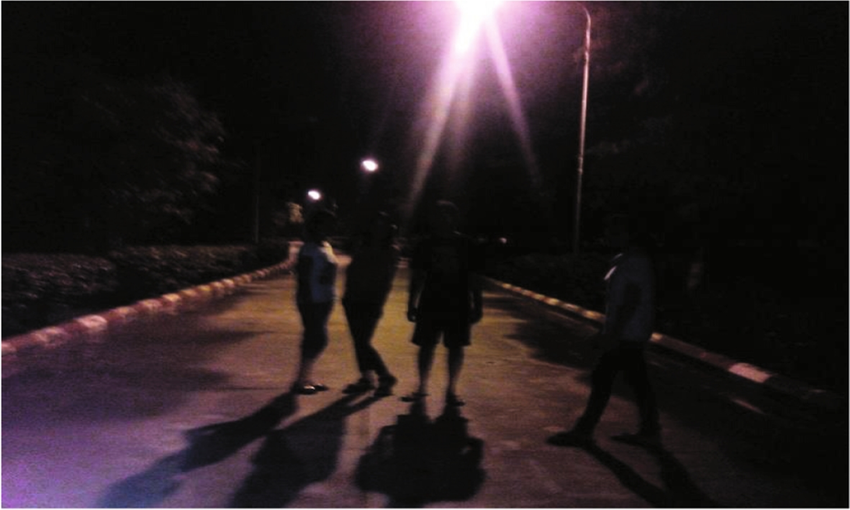

Enhanced Image:


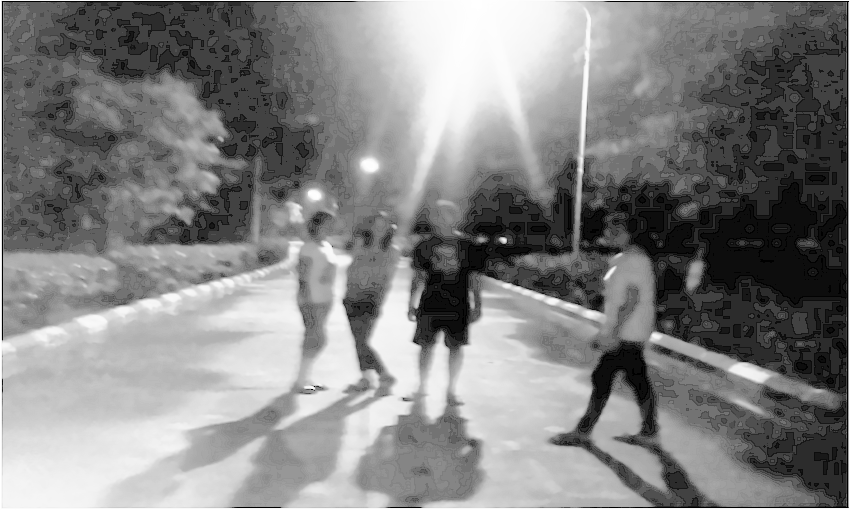

In [7]:
# Cell 6: Display Results
import cv2
from google.colab.patches import cv2_imshow

# Display original image
original_img = cv2.imread("input.png")
if original_img is not None:
    print("Original Image:")
    cv2_imshow(original_img)
else:
    print("Error: Could not load input.png. Ensure Cell 1 was run successfully.")

# Display enhanced image
enhanced_img = cv2.imread("enhanced_image_output.png")
if enhanced_img is not None:
    print("Enhanced Image:")
    cv2_imshow(enhanced_img)
else:
    print("Error: Could not load enhanced_image_output.png. Ensure all previous cells were run successfully.")